In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import ipywidgets as widgets

cuda_input = widgets.BoundedIntText(
    value=0,
    min=0,
    max=1,
    step=1,
    description='GPU to use:',
)
button = widgets.Button(
    description='Set',
    icon='check'
)

def set_gpu_to_use(btn=None):
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cuda_input.value)
    
display(cuda_input)
set_gpu_to_use()
button.on_click(set_gpu_to_use)
display(button)

BoundedIntText(value=0, description='GPU to use:', max=1)

Button(description='Set', icon='check', style=ButtonStyle())

In [3]:
from torch import functional as F
from torch import nn
from torchvision import datasets, transforms, models
import torch

from tqdm import notebook as tqdm
from torch.utils.tensorboard import SummaryWriter

In [4]:
from smoothing import AverageCounter, MovingAverageCounter, AdversarialAttackAugmenter, calculate_radii, get_certified_accuracies

In [31]:
def train(loader, model, criterion, optimizer, writer, epoch, augmenter, device=torch.device('cpu'), skip_minibatches=0):
    assert model.training
    loss_cnt = MovingAverageCounter(5)
    iteration = (epoch - 1) * len(loader.dataset)

    for i, (X, y) in enumerate(tqdm.tqdm(loader)):
        iteration += len(y)
        if i < skip_minibatches:
            continue
        input = X.to(device)
        target = y.to(device).to(torch.float32)
        X_aug, y_aug = augmenter.augment_tensors(input, target, model)
        y_pred = model(X_aug)
        loss = criterion(y_pred, y_aug)
        loss_cnt.add(loss.item())
        
        writer.add_scalar('Loss/train', loss_cnt.get_average(), iteration)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(device))
else:
    device = torch.device('cpu')

NVIDIA Tesla K80


In [7]:
celeba_transforms = [
    transforms.ToTensor(),
#    transforms.Normalize(img_mean, img_std),  # kinda painful to do that with adversarial attacks
]
celeba_transform = transforms.Compose(celeba_transforms)

celeba_transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
] + celeba_transforms)

In [8]:
celeba_train_dataset = datasets.CelebA('dsets/', split='train', target_type='attr',
                                      download=False, transform=celeba_transform_train)

In [9]:
celeba_test_dataset = datasets.CelebA('dsets/', split='valid', target_type='attr',
                                      download=False, transform=celeba_transform)

In [10]:
class CelebaModel(nn.Module):
    def __init__(self):
        super(CelebaModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Linear(2048, 40)

    def forward(self, x):
        return self.resnet50(x)
    
class CelebaModel18(nn.Module):
    def __init__(self):
        super(CelebaModel18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(512, 40)

    def forward(self, x):
        return self.resnet18(x)

In [11]:
batch_size=128

In [12]:
train_loader = torch.utils.data.DataLoader(celeba_train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(celeba_test_dataset, batch_size)

In [13]:
criterion = nn.BCEWithLogitsLoss()
model = CelebaModel18().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
augmenter = AdversarialAttackAugmenter(4, 4.0, 2, 0.5)

In [14]:
writer = SummaryWriter(log_dir='runs/celeba-adv-s05')

In [15]:
def uncertified_validate(loader, model, criterion, writer, epoch, device):
    assert model.training
    try:
        model.eval()
        loss_cnt = AverageCounter()
        accuracy_cnt = AverageCounter()
        with torch.no_grad():
            for X, y in tqdm.tqdm(loader):
                y_pred = model(X.to(device))
                y = y.to(device)
                accuracy_cnt.add(torch.mean(((y_pred > 0) == y).to(torch.float)).item())
                loss = criterion(y_pred, y.to(y_pred.dtype))
                loss_cnt.add(loss.item())
            writer.add_scalar('Loss/val', loss_cnt.get_average(), epoch)
            writer.add_scalar('Accuracy/val', accuracy_cnt.get_average(), epoch)
    finally:
        model.train()

In [16]:
def pl(ax, d, **kwargs):
    radii, res = get_certified_accuracies(d)
    ax.plot(radii, res, **kwargs)

In [32]:
epoch = 2
skip_minibatches = 0
while epoch <= 10:
    print(f'Epoch {epoch}')
    model.train()
    train(train_loader, model, criterion, optimizer, writer, epoch, augmenter, device, skip_minibatches=skip_minibatches)
    torch.save(model, f'celeba-adv{epoch:02d}.pth')
    uncertified_validate(test_loader, model, criterion, writer, epoch, device)
    res_18 = calculate_radii(celeba_test_dataset, range(25), model, 10**2, 10**4, 1e-3, .5, device=device, batch_size=batch_size)
    torch.save(res_18, f'adv-res{epoch:02d}.pth')
    fig, ax = plt.subplots()
    pl(ax, res_18, label='18')
    pl(ax, torch.load('eval10.pth'), label='smoothened')
    writer.add_figure('certified-accuracy', fig, epoch)
    epoch += 1

Epoch 2


  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/1272 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 7


  0%|          | 0/1272 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
model = torch.load('celeba-adv01.pth').to(device)

In [2]:
from scipy.stats import norm, binom_test
from statsmodels.stats.proportion import proportion_confint

In [19]:
N = np.round(np.logspace(2, 10, num=200)).astype(np.int)

In [20]:
res = proportion_confint(N, N, 2e-3, method='beta')[0]

In [21]:
norm.ppf(res)

array([1.50047502, 1.54753929, 1.5898073 , 1.6353699 , 1.67954715,
       1.72222054, 1.76333463, 1.80522075, 1.84720184, 1.88689555,
       1.92620429, 1.96634531, 2.00527816, 2.04291689, 2.08033525,
       2.11820635, 2.15510396, 2.1909077 , 2.22701155, 2.26296174,
       2.29783421, 2.33263445, 2.36654823, 2.40077934, 2.434114  ,
       2.46752153, 2.50033025, 2.53266378, 2.56485244, 2.59685422,
       2.62840502, 2.65969981, 2.69067566, 2.72127406, 2.75172409,
       2.78190015, 2.81181568, 2.84135809, 2.87072168, 2.89984581,
       2.92867234, 2.9573559 , 2.98572768, 3.01394503, 3.04188791,
       3.06960086, 3.09713969, 3.12448548, 3.15157401, 3.17850382,
       3.20523842, 3.23178804, 3.25814307, 3.28430222, 3.31028703,
       3.33611294, 3.36174271, 3.38722081, 3.41252255, 3.43767372,
       3.46265473, 3.48748462, 3.51216055, 3.53668079, 3.5610502 ,
       3.58528247, 3.60936551, 3.63330257, 3.65710952, 3.6807732 ,
       3.70430525, 3.72770574, 3.75097598, 3.77411967, 3.79713

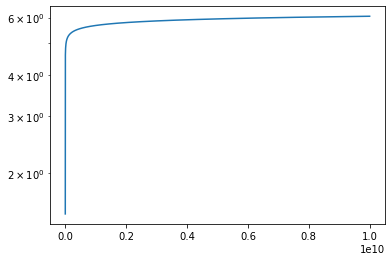

In [22]:
plt.plot(N, norm.ppf(res))
plt.yscale('log')